In [47]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import math
import itertools

## 1. Define Trivial binary function 

$$ g: \mathcal{D} \longrightarrow \mathbb{R} $$
    
where $\mathcal{D}$ is a combinatorial domain (e.g. a set of graphs or molecule structrues). Let $\mathcal{D} = \{1,2,...,d \}$. 

For some $\delta \in \mathcal{D}$, $g(\delta)$ describes the scalar-valued property of graph (e.g. overall utility of a network of bike stations or the solubility of a drug-like molecule).

We model $f$ as affine-linear in presence of each of the $2^{|\mathcal{D}|}$ possible components in $\mathcal{D}$. In particular, let the dummy variable $x_{i}$ describe if a component is present in the combinatorial structure (e.g. a node in a graph or an element in a molecule). In particular, $x_{i} = \mathbb{1}\{ \delta_{i} \in \delta \}$. Restrict to interactions up to order $2$.

$$ f_{\boldsymbol{\alpha}} = \alpha_{0} + \sum_{j=1}^{d} \alpha_{j} x_{j} + \sum_{i<j}^{d} \alpha_{ij}x_{i}x_{j} $$

with $\boldsymbol{\alpha} = (\alpha_{i}, \alpha_{ij}) \in \mathbb{R}^{p}$, $\alpha_{i} \in \mathbb{R}$ and $p=1+d+\binom{d}{k}$.

Let a sample function $f_{1} = \sum \limits_{k \in 2^{|\mathcal{D}|}} \prod \limits_{i=1}^{d} \alpha_{k_{i}} x_{i}$ to be continued.

In [44]:
n, d = 100, 5

np.random.seed(3567)

# X, y
X = np.random.binomial(n=1, p=0.2, size=n*(d+1)).reshape((n,d+1))

# a : groundtruth coefficients
a = np.random.normal(size=2**(d), loc=0, scale=2)
a[1+d+math.comb(d,2):] *= 0.1
a[:1+d+math.comb(d,2)] = abs(a[:1+d+math.comb(d,2)])

a

array([ 5.10814176e-01,  4.74634620e+00,  4.09041707e-01,  1.58249436e+00,
        3.08484411e+00,  8.71464671e-01,  2.52784012e+00,  3.29895566e+00,
        1.58758079e+00,  2.13262363e+00,  4.16389017e-03,  1.63365494e+00,
        2.24979617e-01,  8.06052938e-03,  9.23927220e-01,  2.03100532e+00,
        3.93582388e-02,  2.29598191e-01,  2.32822335e-01, -3.78253033e-02,
       -1.08839234e-01, -5.70600576e-02, -3.90475499e-02,  1.06477088e-01,
       -4.32820489e-03, -3.27991951e-01, -2.06292798e-01,  8.76161980e-02,
        3.25169635e-01, -1.46735122e-01, -2.06126030e-01,  5.82744568e-02])

In [40]:
# groundtruth 


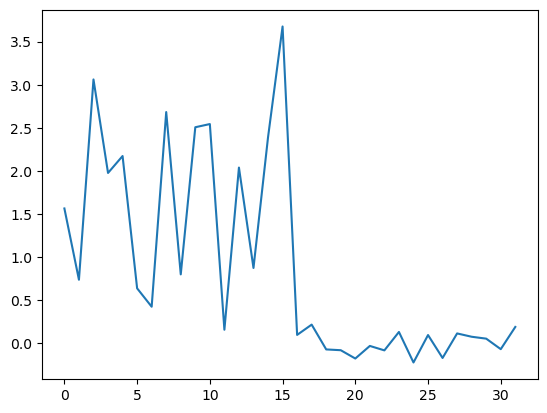

In [41]:
plt.plot(a)

In [56]:
list(itertools.product([0,1], repeat=d))

[(0, 0, 0, 0, 0),
 (0, 0, 0, 0, 1),
 (0, 0, 0, 1, 0),
 (0, 0, 0, 1, 1),
 (0, 0, 1, 0, 0),
 (0, 0, 1, 0, 1),
 (0, 0, 1, 1, 0),
 (0, 0, 1, 1, 1),
 (0, 1, 0, 0, 0),
 (0, 1, 0, 0, 1),
 (0, 1, 0, 1, 0),
 (0, 1, 0, 1, 1),
 (0, 1, 1, 0, 0),
 (0, 1, 1, 0, 1),
 (0, 1, 1, 1, 0),
 (0, 1, 1, 1, 1),
 (1, 0, 0, 0, 0),
 (1, 0, 0, 0, 1),
 (1, 0, 0, 1, 0),
 (1, 0, 0, 1, 1),
 (1, 0, 1, 0, 0),
 (1, 0, 1, 0, 1),
 (1, 0, 1, 1, 0),
 (1, 0, 1, 1, 1),
 (1, 1, 0, 0, 0),
 (1, 1, 0, 0, 1),
 (1, 1, 0, 1, 0),
 (1, 1, 0, 1, 1),
 (1, 1, 1, 0, 0),
 (1, 1, 1, 0, 1),
 (1, 1, 1, 1, 0),
 (1, 1, 1, 1, 1)]